In [1]:
df_acumulados<-read.csv("https://covid19.isciii.es/resources/serie_historica_acumulados.csv",
                       col.names=c("CCAA","Fecha","Casos","Hospitalizados","UCI","Fallecidos","Recuperados"))
df_acumulados$Fecha<-as.Date(df_acumulados$Fecha,format="%d/%m/%Y")
head(df_acumulados)

CCAA,Fecha,Casos,Hospitalizados,UCI,Fallecidos,Recuperados
<fct>,<date>,<int>,<int>,<int>,<int>,<int>
AN,2020-02-20,NA,NA,NA,NA,NA
AR,2020-02-20,NA,NA,NA,NA,NA
AS,2020-02-20,NA,NA,NA,NA,NA
IB,2020-02-20,1,NA,NA,NA,NA
CN,2020-02-20,1,NA,NA,NA,NA
CB,2020-02-20,NA,NA,NA,NA,NA


In [2]:
df_acumulados<-df_acumulados[1:(nrow(df_acumulados)-2),]

In [3]:
tail(df_acumulados)

,CCAA,Fecha,Casos,Hospitalizados,UCI,Fallecidos,Recuperados
,<fct>,<date>,<int>,<int>,<int>,<int>,<int>
946,ML,2020-04-09,95,41,3,2,17
947,MC,2020-04-09,1383,533,88,90,255
948,NC,2020-04-09,3748,1620,124,218,560
949,PV,2020-04-09,10103,5290,442,729,4680
950,RI,2020-04-09,3076,1047,71,196,1256
951,,NA,NA,NA,NA,NA,NA


In [4]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [5]:
df_acumulados_all<-df_acumulados %>% group_by(Fecha) %>% summarise_at(c("Casos","Hospitalizados","UCI","Fallecidos","Recuperados"), 
                                                   sum, na.rm = TRUE)

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”

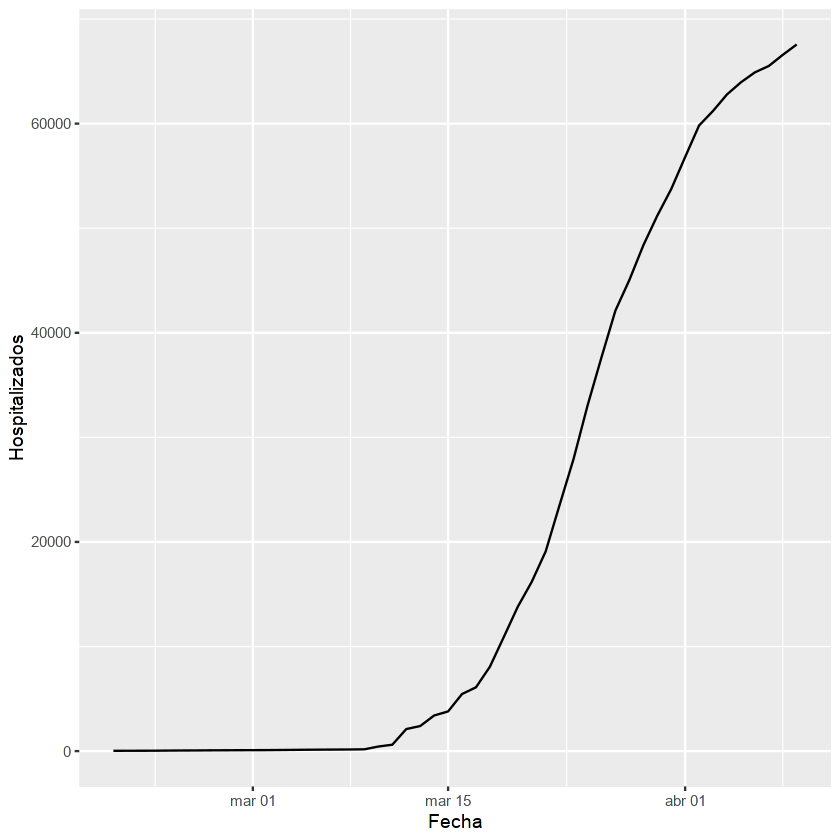

In [6]:
library(ggplot2)
ggplot(df_acumulados_all,aes(x=Fecha,y=Hospitalizados))+geom_line()

In [7]:
df_casos<-apply(df_acumulados_all[,c("Casos","Hospitalizados","UCI","Fallecidos","Recuperados")],2,diff)
df_casos<-as.data.frame(df_casos)
df_casos$Fecha<-df_acumulados_all$Fecha[2:nrow(df_acumulados_all)]
df_casos<-df_casos[df_casos$Fecha>as.Date("2020-03-06"),]
df_casos$day<-1:nrow(df_casos)

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”Warning message:
“Removed 1 row(s) containing missing values (geom_path).”Warning message:
“Removed 1 row(s) containing missing values (geom_path).”

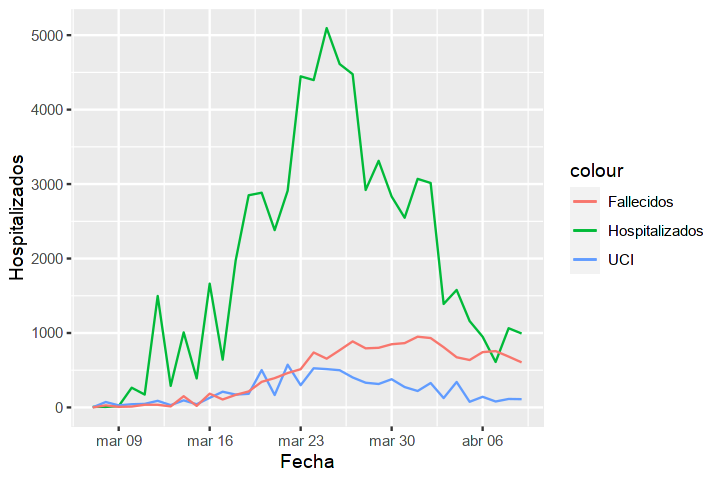

In [8]:
library(ggplot2)
options(repr.plot.height=4,repr.plot.width=6)

ggplot(df_casos,aes(x=Fecha))+
    geom_line(aes(y=Hospitalizados,color="Hospitalizados"))+
    geom_line(aes(y=UCI,color="UCI"))+
    geom_line(aes(y=Fallecidos,color="Fallecidos"))



Call:
glm(formula = Hospitalizados ~ day + I(day^2), family = quasipoisson, 
    data = df_casos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-27.878  -10.737   -3.861    8.317   38.656  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.849239   0.419986   9.165 2.46e-10 ***
day          0.443675   0.044204  10.037 2.93e-11 ***
I(day^2)    -0.011029   0.001113  -9.909 3.98e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 223.02)

    Null deviance: 42980.8  on 33  degrees of freedom
Residual deviance:  6400.3  on 31  degrees of freedom
  (1 observation deleted due to missingness)
AIC: NA

Number of Fisher Scoring iterations: 5



Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date

Warning message:
“Removed 11 rows containing missing values (position_stack).”

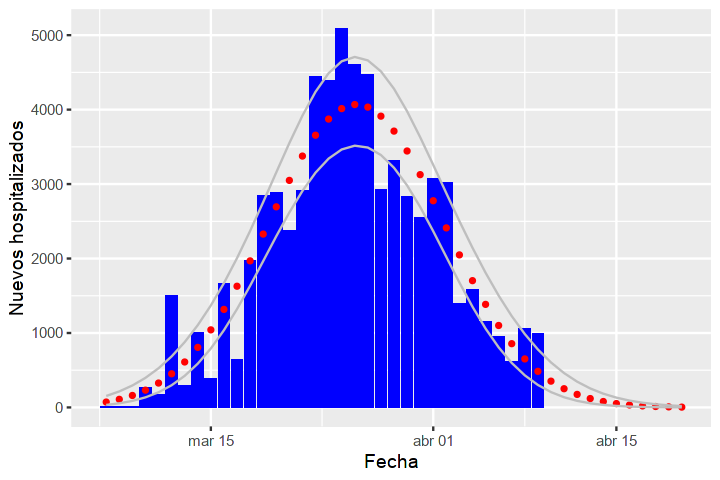

In [9]:
model<-glm(formula=Hospitalizados~day+I(day^2),data=df_casos,family=quasipoisson)
summary(model)

library(lubridate)
ilink <- family(model)$linkinv

future_days<-10
df_futuro<-df_casos
df_futuro[nrow(df_futuro)+future_days,] <- NA
df_futuro$day<-1:(nrow(df_casos)+future_days)


pred<-predict(model,df_futuro,type="link",se.fit = TRUE)
df_futuro$pred<-predict(model,df_futuro,type="response")
df_futuro$pred_lwr<-ilink(pred$fit - (2 * pred$se.fit))
df_futuro$pred_upr<-ilink(pred$fit + (2 * pred$se.fit))
df_futuro$Fecha[is.na(df_futuro$Fecha)]<-df_futuro$Fecha[1]+days(df_futuro$day[is.na(df_futuro$Fecha)]-1)
ggplot(df_futuro,aes(x=Fecha,y=Hospitalizados))+geom_col(size=1,fill="blue")+
  geom_point(size=1,color="red",aes(y=pred))+
  geom_line(size=0.5,color="gray",aes(y=pred_upr))+
  geom_line(size=0.5,color="gray",aes(y=pred_lwr))+
    #scale_x_continuous(breaks = scales::pretty_breaks(n = 10)) +
ylab("Nuevos hospitalizados")



Call:
glm(formula = Fallecidos ~ day + I(sqrt(day)), family = quasipoisson, 
    data = df_casos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-9.9683  -1.2914   0.0001   2.0982  11.0246  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -5.8336     1.4458  -4.035 0.000332 ***
day           -0.4897     0.0699  -7.007 7.27e-08 ***
I(sqrt(day))   4.9630     0.6403   7.751 9.58e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 32.86254)

    Null deviance: 10709.59  on 33  degrees of freedom
Residual deviance:   581.16  on 31  degrees of freedom
  (1 observation deleted due to missingness)
AIC: NA

Number of Fisher Scoring iterations: 5


Warning message:
“Removed 11 rows containing missing values (position_stack).”

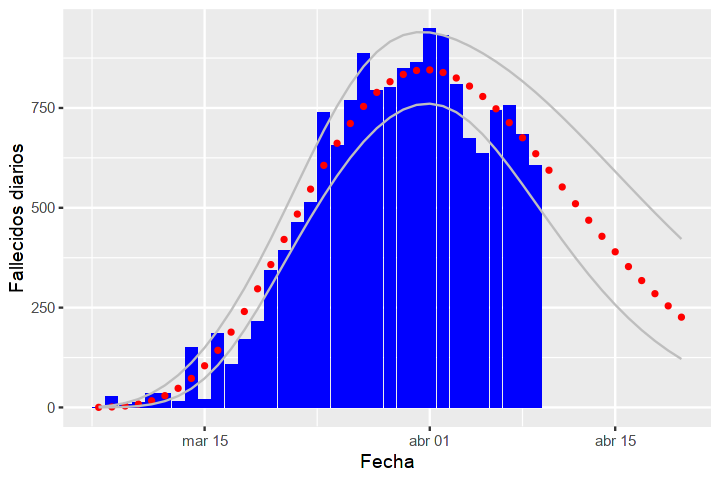

In [10]:
model<-glm(formula=Fallecidos~day+I(sqrt(day)),data=df_casos,family=quasipoisson)
summary(model)

ilink <- family(model)$linkinv

future_days<-10
df_futuro<-df_casos
df_futuro[nrow(df_futuro)+future_days,] <- NA
df_futuro$day<-1:(nrow(df_casos)+future_days)


pred<-predict(model,df_futuro,type="link",se.fit = TRUE)
df_futuro$pred<-predict(model,df_futuro,type="response")
df_futuro$pred_lwr<-ilink(pred$fit - (2 * pred$se.fit))
df_futuro$pred_upr<-ilink(pred$fit + (2 * pred$se.fit))
df_futuro$Fecha[is.na(df_futuro$Fecha)]<-df_futuro$Fecha[1]+days(df_futuro$day[is.na(df_futuro$Fecha)]-1)
ggplot(df_futuro,aes(x=Fecha,y=Fallecidos))+geom_col(size=1,fill="blue")+
  geom_point(size=1,color="red",aes(y=pred))+
  geom_line(size=0.5,color="gray",aes(y=pred_upr))+
  geom_line(size=0.5,color="gray",aes(y=pred_lwr))+
    #scale_x_continuous(breaks = scales::pretty_breaks(n = 10)) +
ylab("Fallecidos diarios")


In [11]:
col<-""


Call:
glm(formula = UCI ~ day + I(sqrt(day)), family = quasipoisson, 
    data = df_casos)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-11.032   -4.963   -1.225    3.685   15.966  

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -3.6991     1.8783  -1.969   0.0579 .  
day           -0.5238     0.1069  -4.900 2.86e-05 ***
I(sqrt(day))   4.4971     0.9052   4.968 2.35e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for quasipoisson family taken to be 62.79273)

    Null deviance: 4381.2  on 33  degrees of freedom
Residual deviance: 1337.1  on 31  degrees of freedom
  (1 observation deleted due to missingness)
AIC: NA

Number of Fisher Scoring iterations: 5


Warning message:
“Removed 11 rows containing missing values (position_stack).”

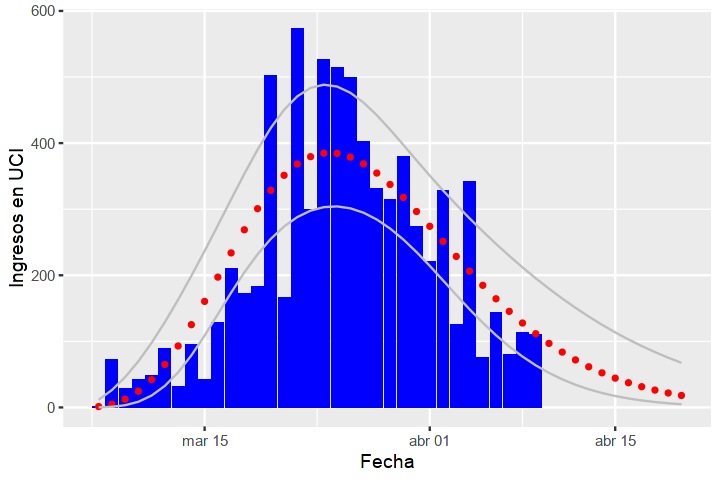

In [12]:
model<-glm(formula=UCI~day+I(sqrt(day)),data=df_casos,family=quasipoisson)
summary(model)

ilink <- family(model)$linkinv

future_days<-10
df_futuro<-df_casos
df_futuro[nrow(df_futuro)+future_days,] <- NA
df_futuro$day<-1:(nrow(df_casos)+future_days)


pred<-predict(model,df_futuro,type="link",se.fit = TRUE)
df_futuro$pred<-predict(model,df_futuro,type="response")
df_futuro$pred_lwr<-ilink(pred$fit - (2 * pred$se.fit))
df_futuro$pred_upr<-ilink(pred$fit + (2 * pred$se.fit))
df_futuro$Fecha[is.na(df_futuro$Fecha)]<-df_futuro$Fecha[1]+days(df_futuro$day[is.na(df_futuro$Fecha)]-1)
ggplot(df_futuro,aes(x=Fecha,y=UCI))+geom_col(size=1,fill="blue")+
  geom_point(size=1,color="red",aes(y=pred))+
  geom_line(size=0.5,color="gray",aes(y=pred_upr))+
  geom_line(size=0.5,color="gray",aes(y=pred_lwr))+
    #scale_x_continuous(breaks = scales::pretty_breaks(n = 10)) +
ylab("Ingresos en UCI")
